In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
diamonds_df = pd.read_csv('noisy_datasets/diamond.csv')
print(diamonds_df.head())
diamonds_df = diamonds_df.drop(columns=['Unnamed: 0'])
print('Dropping column \"Unnamed: 0\" since it is jut indexing')

  Unnamed: 0 carat      cut color clarity  average us salary  \
0          1  0.23    Ideal     E     SI2              31282   
1          2  0.21  Premium     E     SI1              40049   
2          3  0.23     Good     E     VS1              33517   
3          4  0.29  Premium     I     VS2              38495   
4          5  0.31     Good     J     SI2              34178   

   number of diamonds mined (millions) depth table price     x     y     z  
0                                 5.01  61.5    55   326  3.95  3.98  2.43  
1                                 1.69  59.8    61   326  3.89  3.84  2.31  
2                                 3.85  56.9    65   327  4.05  4.07  2.31  
3                                 3.49  62.4    58   334   4.2  4.23  2.63  
4                                 4.70  63.3    58   335  4.34  4.35  2.75  
Dropping column "Unnamed: 0" since it is jut indexing


In [3]:
diamonds_df = pd.read_csv('noisy_datasets/diamond.csv')
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           53563 non-null  object 
 1   carat                                52430 non-null  object 
 2   cut                                  52647 non-null  object 
 3   color                                52428 non-null  object 
 4   clarity                              53587 non-null  object 
 5   average us salary                    53940 non-null  int64  
 6   number of diamonds mined (millions)  53940 non-null  float64
 7   depth                                53246 non-null  object 
 8   table                                52398 non-null  object 
 9   price                                52357 non-null  object 
 10  x                                    52414 non-null  object 
 11  y                           

In [4]:
diamonds_df = diamonds_df.drop(columns=['Unnamed: 0'], errors='ignore')
print("Dropped Unnamed: 0 as it is only indexing")
print(diamonds_df.info())
for cols in diamonds_df.columns:
        if cols in ['depth', 'table', 'price', 'carat', 'x', 'y', 'z']:
            diamonds_df[cols] = pd.to_numeric(diamonds_df[cols], errors = 'coerce')
            diamonds_df[cols] = diamonds_df[cols].fillna(diamonds_df[cols].median())
            Q1 = diamonds_df[cols].quantile(0.25)
            Q3 = diamonds_df[cols].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR    
            diamonds_df = diamonds_df[(diamonds_df[cols] >= lower_bound) & (diamonds_df[cols] <= upper_bound)]
        if cols in ['cut', 'color', 'clarity']:
            diamonds_df.dropna(subset=[cols], inplace=True)
            diamonds_df[cols] = diamonds_df[cols].str.lower()
            diamonds_df[cols] = pd.Categorical(diamonds_df[cols]).codes

Dropped Unnamed: 0 as it is only indexing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   carat                                52430 non-null  object 
 1   cut                                  52647 non-null  object 
 2   color                                52428 non-null  object 
 3   clarity                              53587 non-null  object 
 4   average us salary                    53940 non-null  int64  
 5   number of diamonds mined (millions)  53940 non-null  float64
 6   depth                                53246 non-null  object 
 7   table                                52398 non-null  object 
 8   price                                52357 non-null  object 
 9   x                                    52414 non-null  object 
 10  y                                    52719 non-null 

In [5]:
print(diamonds_df.isnull().sum())

carat                                  0
cut                                    0
color                                  0
clarity                                0
average us salary                      0
number of diamonds mined (millions)    0
depth                                  0
table                                  0
price                                  0
x                                      0
y                                      0
z                                      0
dtype: int64


In [6]:
X = diamonds_df.drop(columns=['price']).values
Y = diamonds_df['price'].values.reshape(-1, 1)
N = X.shape[0]
trainSize = int(0.8 * N)
indexNumber = np.arange(N)
np.random.shuffle(indexNumber)
train_indices = indexNumber[:trainSize]
test_indices = indexNumber[trainSize:]
X_train = X[:trainSize]
Y_train = Y[:trainSize]
X_test = X[trainSize:]
Y_test = Y[trainSize:]

min_values_x = X_train.min(axis=0)
max_values_x = X_train.max(axis=0)
min_values_xt = X_test.min(axis=0)
max_values_xt = X_test.max(axis=0)
min_values_y = Y_train.min(axis = 0)
max_values_y = Y_train.max(axis = 0)
min_values_yt = Y_test.min(axis = 0)
max_values_yt = Y_test.max(axis = 0)
X_train_normalized = (X_train - min_values_x) / (max_values_x - min_values_x)
X_test_normalized = (X_test - min_values_xt) / (max_values_xt - min_values_xt)
y_train_normalized = (Y_train - min_values_y) / (max_values_y - min_values_y)
y_test_normalized = (Y_test - min_values_yt) / (max_values_yt - min_values_yt)
print("X train normalized shape:", X_train_normalized.shape)
print("y train normalized shape:", y_train_normalized.shape)
print("X test normalized shape:", X_test_normalized.shape)
print("y test normalized shape:", y_test_normalized.shape)

X train normalized shape: (35356, 11)
y train normalized shape: (35356, 1)
X test normalized shape: (8839, 11)
y test normalized shape: (8839, 1)


In [7]:
class ElasticNetRegularization:
    def __init__(self, learning_rate, iterations, lambda1, lambda2, threshold=None):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda1 = lambda1  
        self.lambda2 = lambda2  
        self.weights = None
        self.loss_history = []
        self.bias = 0
        self.threshold = threshold  

    def initialize_weights(self, method='Random', input_dim=None):
        if method == 'Random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1))
        elif method == 'Zero':
            self.weights = np.zeros((input_dim, 1))
        elif method == 'Xavier':
            limit = np.sqrt(6 / (input_dim + 1)) 
            self.weights = np.random.uniform(-limit, limit, (input_dim, 1))
        else:
            raise ValueError("Unknown weight initialization method.")

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def cost(self, y, y_pred):
        N = len(y)
        mse = (1 / (2 * N)) * np.sum((y_pred - y) ** 2) 
        l1_penalty = self.lambda1 * np.sum(np.abs(self.weights))
        l2_penalty = (self.lambda2 / 2) * np.sum(self.weights ** 2)
        return mse + l1_penalty + l2_penalty

    def gradient(self, X, y):
        N = len(y)
        y_pred = np.dot(X, self.weights) + self.bias
        residual = y_pred - y
        dW = (1 / N) * np.dot(X.T, residual) + self.lambda1 * np.sign(self.weights) + self.lambda2 * self.weights
        db = np.sum(residual) / N
        return dW, db

    def fit(self, X, y, init_method):
        self.initialize_weights(method=init_method, input_dim=X.shape[1])
        
        for i in range(self.iterations):
            dW, db = self.gradient(X, y)
            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db
            
            cost_value = self.cost(y, np.dot(X, self.weights) + self.bias)
            self.loss_history.append(cost_value)
            if self.threshold and np.linalg.norm(dW) < self.threshold:
                print(f"Stopping early at iteration {i} due to small gradient. Final Loss: {cost_value}")
                break

            if i % 1000 == 0:
                print(f"Iteration {i}: Loss is {cost_value}")

        print(f"Completed all iterations. Final Loss: {cost_value}")

    def plot_loss(self):
        plt.plot(range(len(self.loss_history)), self.loss_history)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss Over Iterations')
        plt.show()

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6)) 
    plt.scatter(y_true, y_pred, alpha=0.7, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],color='red', linestyle='-')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid()
    plt.show()

def save_model_weights_as_pickle(model, filename="best_model_weights.pkl"):
    model_weights = {
        "weights": model.weights,
        "bias": model.bias}
    with open(filename, 'wb') as f:
        pickle.dump(model_weights, f)



Training model with Random initialization:
Running for fixed iterations:
Iteration 0: Loss is 0.15863078911716988
Iteration 1000: Loss is 0.1259060387837665
Iteration 2000: Loss is 0.10664837178800561
Iteration 3000: Loss is 0.09106655091692537
Iteration 4000: Loss is 0.07834846897011732
Iteration 5000: Loss is 0.06785844104297105
Iteration 6000: Loss is 0.0591521125076644
Iteration 7000: Loss is 0.05188292657277293
Iteration 8000: Loss is 0.04577915076457281
Iteration 9000: Loss is 0.04062651386238473
Iteration 10000: Loss is 0.036255052807723086
Iteration 11000: Loss is 0.03252912302222822
Iteration 12000: Loss is 0.029339789323594042
Iteration 13000: Loss is 0.026599011416777785
Iteration 14000: Loss is 0.024235184830694357
Iteration 15000: Loss is 0.02218970787795955
Iteration 16000: Loss is 0.02041432720101861
Iteration 17000: Loss is 0.018869075780477484
Iteration 18000: Loss is 0.0175206631708537
Iteration 19000: Loss is 0.016341212106962575
Iteration 20000: Loss is 0.015307261

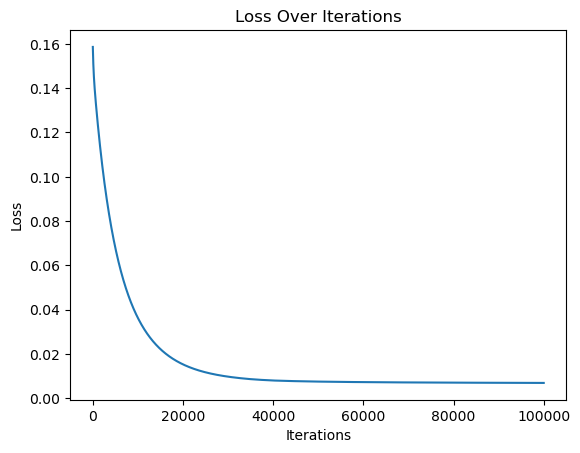

Plotting Actual vs Predicted for fixed iterations:


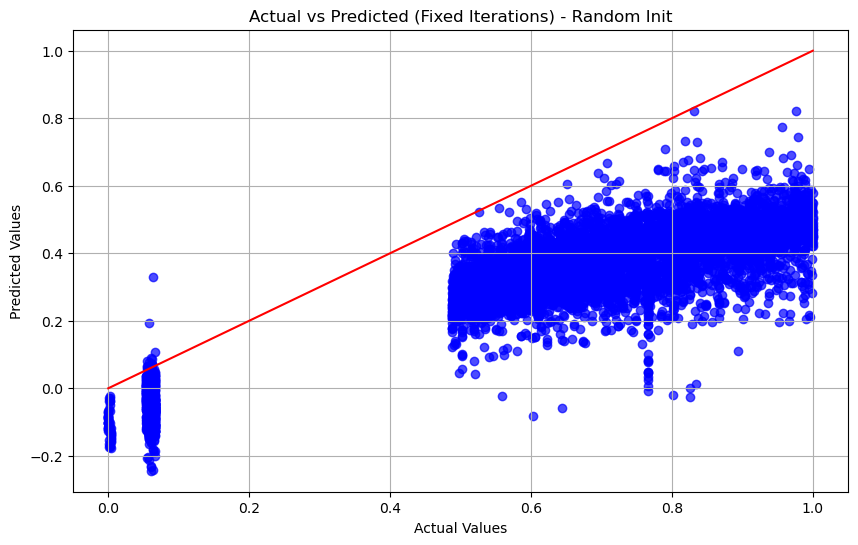

Running with gradient threshold stopping criteria:
Iteration 0: Loss is 0.8439653230408277
Iteration 1000: Loss is 0.0801085129497297
Iteration 2000: Loss is 0.07073969734006455
Iteration 3000: Loss is 0.063122935203799
Iteration 4000: Loss is 0.05650813933994479
Iteration 5000: Loss is 0.050756371685376646
Iteration 6000: Loss is 0.04574911851474317
Iteration 7000: Loss is 0.04138481440847097
Iteration 8000: Loss is 0.037576308728829354
Iteration 9000: Loss is 0.03424873280604781
Iteration 10000: Loss is 0.0313376995265444
Iteration 11000: Loss is 0.02878777991874384
Iteration 12000: Loss is 0.026551211351078425
Iteration 13000: Loss is 0.024586799998509313
Iteration 14000: Loss is 0.022858986721433033
Iteration 15000: Loss is 0.021337050760575217
Iteration 16000: Loss is 0.019994429936438456
Iteration 17000: Loss is 0.01880813954900051
Iteration 18000: Loss is 0.01775827505664839
Iteration 19000: Loss is 0.016827585993750324
Iteration 20000: Loss is 0.016001110559314555
Iteration 210

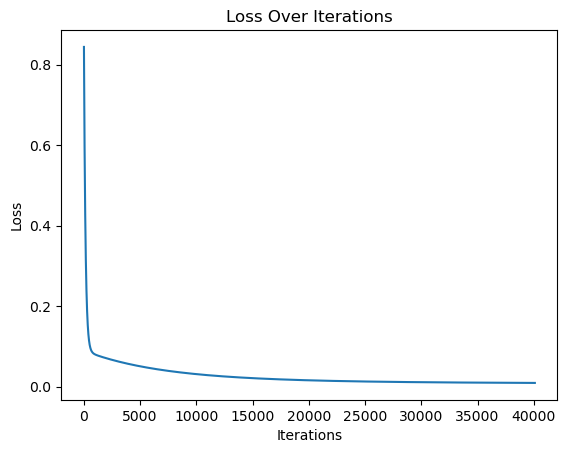

Plotting Actual vs Predicted for gradient threshold:


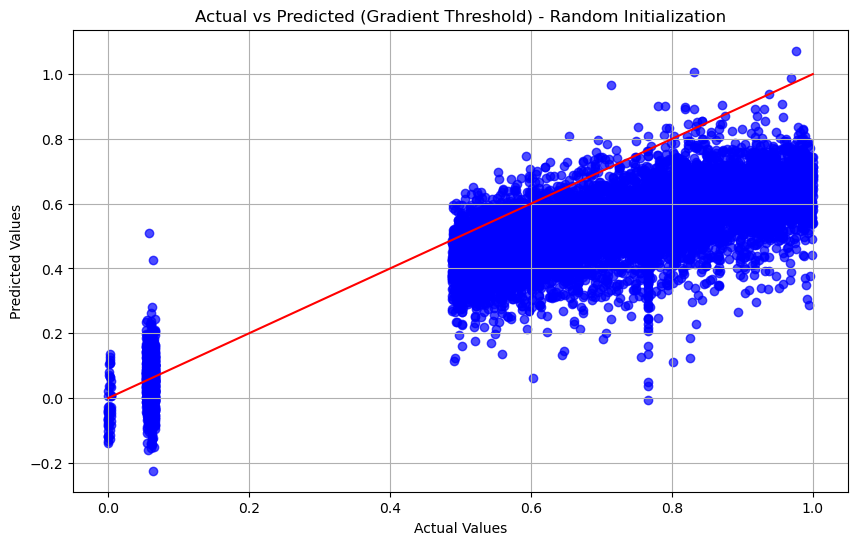


Training model with Zero initialization:
Running for fixed iterations:
Iteration 0: Loss is 0.07204377358945782
Iteration 1000: Loss is 0.02374488798172963
Iteration 2000: Loss is 0.019753133878360963
Iteration 3000: Loss is 0.01676524022835017
Iteration 4000: Loss is 0.014502947583192372
Iteration 5000: Loss is 0.012799159027706777
Iteration 6000: Loss is 0.011525790891778728
Iteration 7000: Loss is 0.010563348267112839
Iteration 8000: Loss is 0.00982494361847768
Iteration 9000: Loss is 0.009244401946201046
Iteration 10000: Loss is 0.008793138903800225
Iteration 11000: Loss is 0.008443733038869385
Iteration 12000: Loss is 0.008172062354401653
Iteration 13000: Loss is 0.007955774955193243
Iteration 14000: Loss is 0.0077817062963450225
Iteration 15000: Loss is 0.0076399783998918475
Iteration 16000: Loss is 0.007523164999433307
Iteration 17000: Loss is 0.007425670798173311
Iteration 18000: Loss is 0.007343269016868018
Iteration 19000: Loss is 0.007272756757454453
Iteration 20000: Loss i

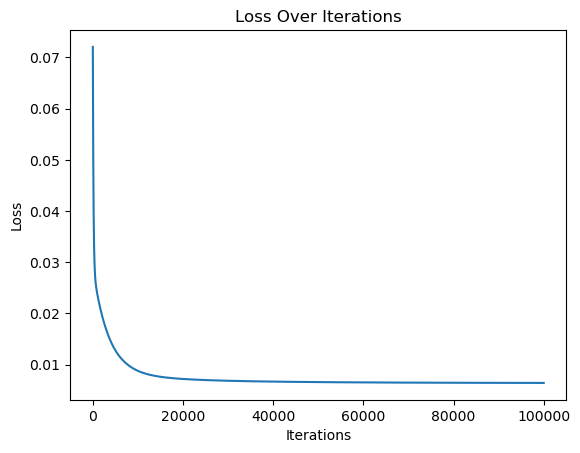

Plotting Actual vs Predicted for fixed iterations:


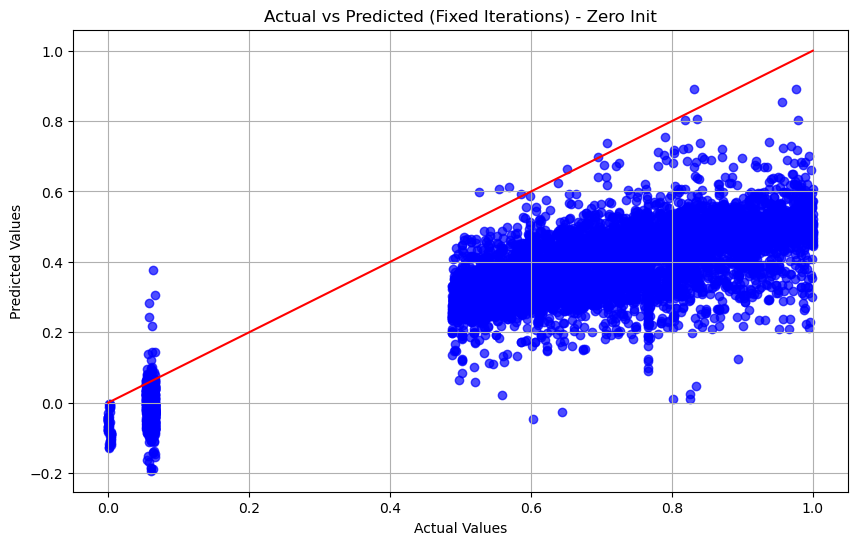

Running with gradient threshold stopping criteria:
Iteration 0: Loss is 0.07204377358945782
Iteration 1000: Loss is 0.02374488798172963
Iteration 2000: Loss is 0.019753133878360963
Iteration 3000: Loss is 0.01676524022835017
Iteration 4000: Loss is 0.014502947583192372
Iteration 5000: Loss is 0.012799159027706777
Iteration 6000: Loss is 0.011525790891778728
Iteration 7000: Loss is 0.010563348267112839
Iteration 8000: Loss is 0.00982494361847768
Iteration 9000: Loss is 0.009244401946201046
Iteration 10000: Loss is 0.008793138903800225
Iteration 11000: Loss is 0.008443733038869385
Iteration 12000: Loss is 0.008172062354401653
Iteration 13000: Loss is 0.007955774955193243
Iteration 14000: Loss is 0.0077817062963450225
Iteration 15000: Loss is 0.0076399783998918475
Stopping early at iteration 15028 due to small gradient. Final Loss: 0.007636398393259116
Completed all iterations. Final Loss: 0.007636398393259116
Test MSE (Gradient Threshold): 0.06124
Loss plot for gradient threshold:


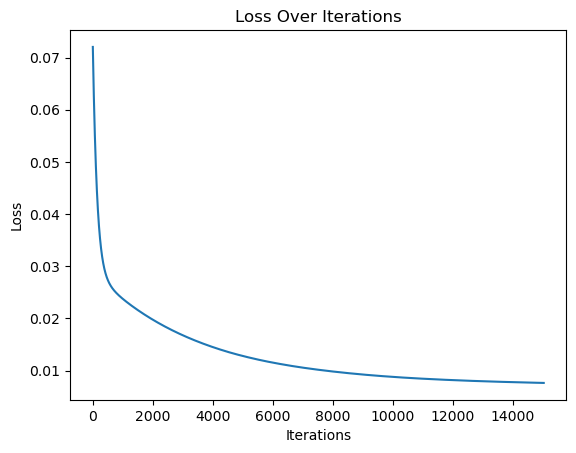

Plotting Actual vs Predicted for gradient threshold:


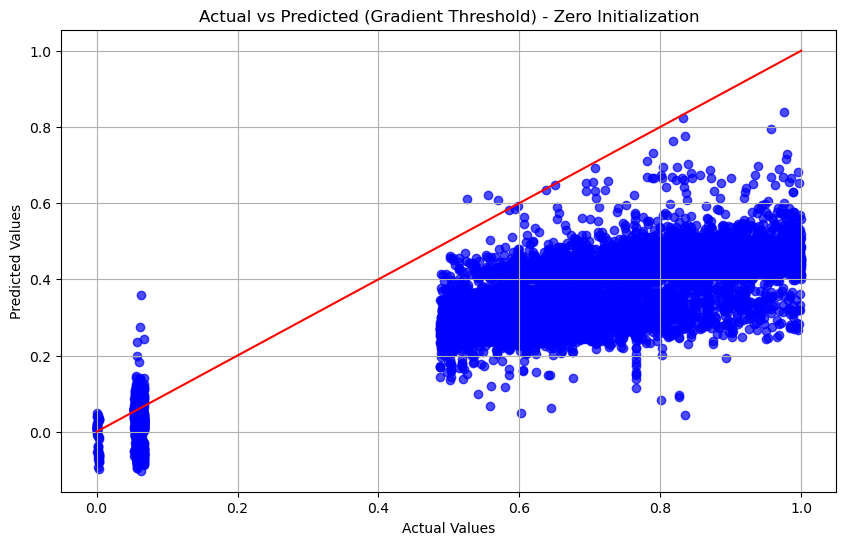


Training model with Xavier initialization:
Running for fixed iterations:
Iteration 0: Loss is 0.060277745995791436
Iteration 1000: Loss is 0.030604524504359434
Iteration 2000: Loss is 0.027410020178344978
Iteration 3000: Loss is 0.024683434812160537
Iteration 4000: Loss is 0.022348273452667898
Iteration 5000: Loss is 0.020335104922918953
Iteration 6000: Loss is 0.018597580916177872
Iteration 7000: Loss is 0.01709622754853456
Iteration 8000: Loss is 0.01579738922977832
Iteration 9000: Loss is 0.014672345398511552
Iteration 10000: Loss is 0.013696566463759321
Iteration 11000: Loss is 0.012849085886804527
Iteration 12000: Loss is 0.012111969414210751
Iteration 13000: Loss is 0.011469865771151267
Iteration 14000: Loss is 0.01090962580655843
Iteration 15000: Loss is 0.010419979272324369
Iteration 16000: Loss is 0.009991260215079198
Iteration 17000: Loss is 0.009615173437517575
Iteration 18000: Loss is 0.009286359053367593
Iteration 19000: Loss is 0.009015563846813356
Iteration 20000: Loss 

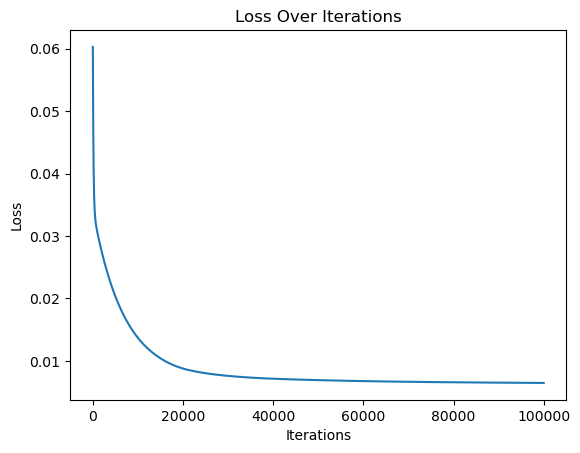

Plotting Actual vs Predicted for fixed iterations:


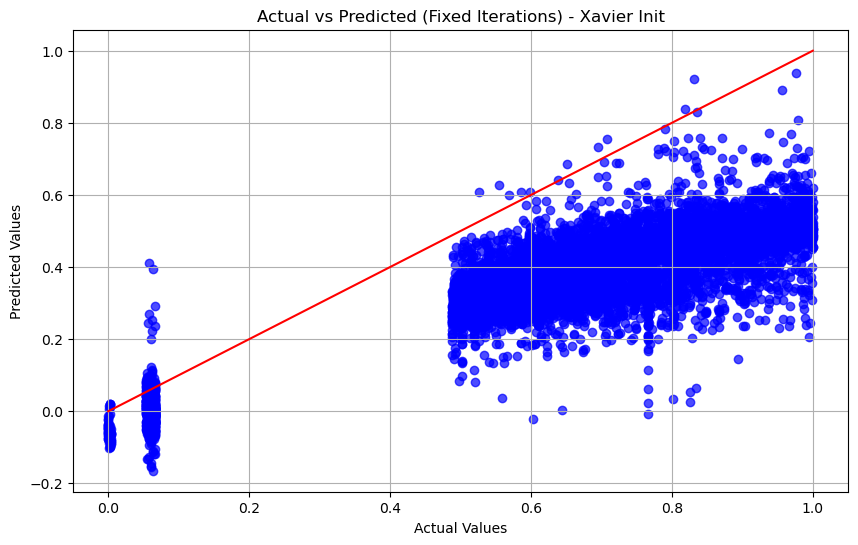

Running with gradient threshold stopping criteria:
Iteration 0: Loss is 0.2465964885733892
Iteration 1000: Loss is 0.11314258081269792
Iteration 2000: Loss is 0.09385042150990637
Iteration 3000: Loss is 0.07855649747434025
Iteration 4000: Loss is 0.066248249313655
Iteration 5000: Loss is 0.056477909292071526
Iteration 6000: Loss is 0.04853280687020739
Iteration 7000: Loss is 0.04204587169065989
Iteration 8000: Loss is 0.03676246784597957
Iteration 9000: Loss is 0.032373830006884895
Iteration 10000: Loss is 0.028708781553146948
Iteration 11000: Loss is 0.02563224497868807
Iteration 12000: Loss is 0.023037068278549757
Iteration 13000: Loss is 0.020837793277046893
Iteration 14000: Loss is 0.018965889265342394
Iteration 15000: Loss is 0.017366095620382768
Iteration 16000: Loss is 0.015993605546640526
Iteration 17000: Loss is 0.014811889307618214
Iteration 18000: Loss is 0.013791004931592628
Iteration 19000: Loss is 0.012906281586300885
Iteration 20000: Loss is 0.012137288752942323
Iteratio

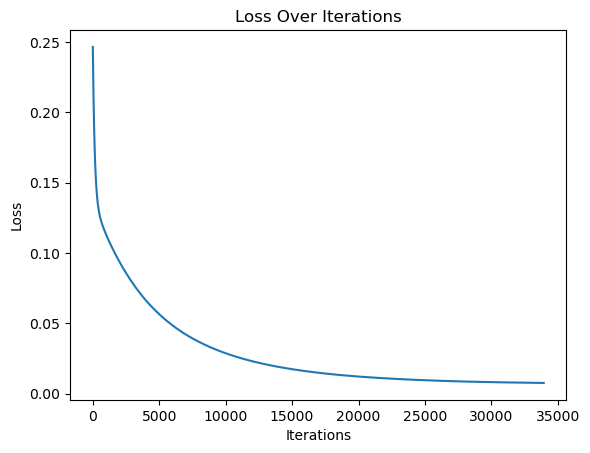

Plotting Actual vs Predicted for gradient threshold:


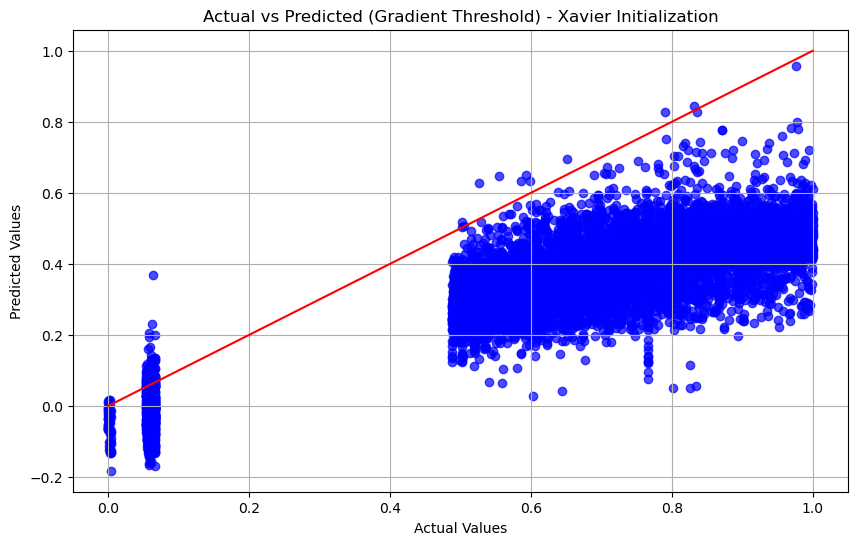

In [8]:
# Hyperparameters
learning_rate = 0.001 
iterations_count = 100000 
lambda1 = 0.001  
lambda2 = 0.001  
threshold = 0.01  
initialization_methods = ['Random', 'Zero', 'Xavier']

best_mse = float('inf')
best_method = None
best_criteria = None
best_model = None

for init_method in initialization_methods:
    print(f"\nTraining model with {init_method} initialization:")
    print("Running for fixed iterations:")
    model_fixed_iterations = ElasticNetRegularization(learning_rate, iterations_count, lambda1, lambda2)
    model_fixed_iterations.fit(X_train_normalized, y_train_normalized, init_method=init_method)
    y_test_normalized_fixed_pred = model_fixed_iterations.predict(X_test_normalized)
    mse_fixed_normalized = (1 / (2 * len(y_train_normalized))) * np.sum((y_test_normalized - y_test_normalized_fixed_pred) ** 2)
    print(f"Test MSE (Fixed Iterations): {mse_fixed_normalized:.5f}")

    print("Loss plot for fixed iterations:")
    model_fixed_iterations.plot_loss()
    print("Plotting Actual vs Predicted for fixed iterations:")
    plot_actual_vs_predicted(y_test_normalized, y_test_normalized_fixed_pred, f'Actual vs Predicted (Fixed Iterations) - {init_method} Init')

    if mse_fixed_normalized < best_mse:
        best_mse = mse_fixed_normalized
        best_method = init_method
        best_criteria = "Fixed Iterations"
        best_model = model_fixed_iterations
    print("Running with gradient threshold stopping criteria:")
    model_gradient_threshold = ElasticNetRegularization(learning_rate, iterations_count, lambda1, lambda2, threshold=threshold)
    model_gradient_threshold.fit(X_train_normalized, y_train_normalized, init_method=init_method)
    
    y_test_normalized_threshold_pred = model_gradient_threshold.predict(X_test_normalized)
    mse_threshold_normalized = (1 / (2 * len(y_test_normalized))) * np.sum((y_test_normalized - y_test_normalized_threshold_pred) ** 2)
    print(f"Test MSE (Gradient Threshold): {mse_threshold_normalized:.5f}")

    print("Loss plot for gradient threshold:")
    model_gradient_threshold.plot_loss()
    print("Plotting Actual vs Predicted for gradient threshold:")
    plot_actual_vs_predicted(y_test_normalized, y_test_normalized_threshold_pred, f'Actual vs Predicted (Gradient Threshold) - {init_method} Initialization')
    
    if mse_threshold_normalized < best_mse:
        best_mse = mse_threshold_normalized
        best_method = init_method
        best_criteria = "Gradient Threshold"
        best_model = model_gradient_threshold

In [9]:
print(f"\nBest performing method: {best_method} initialization with {best_criteria} stopping criteria.")
print(f"Lowest MSE: {best_mse:.5f}")
save_model_weights_as_pickle(best_model, filename="mythrish_ruthvikv_assignment1_part4.pkl")


Best performing method: Xavier initialization with Fixed Iterations stopping criteria.
Lowest MSE: 0.01277
